**Analyze Word Frequency Counts Using Twitter Data and Tweepy in Python**

**Reference**
- It is the example in this link just added more explanation
- https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/

**Example objectives:**

- Take a set of tweets and clean them, in order to analyze the frequency of words found in the tweets. 

- Remove URLs from tweets.
- Clean up tweet text, including differences in case (e.g. upper, lower) that will affect unique word counts and removing words that are not useful for the analysis.
- Summarize and count words found in tweets.

**Get Tweets Related to Climate**
- When you work with social media and other text data, the user community creates and curates the content. This means there are NO RULES! This also means that you may have to perform extra steps to clean the data to ensure you are analyzing the right thing.

- Next, you will explore the text associated with a set of tweets that you access using Tweepy and the Twitter API. You will use some standard natural language processing (also known as text mining) approaches to do this.

In [6]:
#import os to deal with files on the operating system
import os

#import pandas to deal with dataframes and more
import pandas as pd

#import visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

#import collections to deal with collections
import collections

#import tweepy to deal with the tweets
import tweepy as tweepy

#import nltk to deal with natural processing language
#we will study that in details in our Natural Processing course in AI for Business certificate
import nltk
from nltk.corpus import stopwords
import re
import networkx

#to filter warnings

import warnings
warnings.filterwarnings("ignore")

#setting some configurations for seaborn related plots
#setting the background style and font scale 
#those are optional but makes the plots look nicer
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

- The keys

In [7]:
#import libraries that you need
import tweepy
from tweepy import OAuthHandler, Stream
from credentials import *

# Go to https://developer.twitter.com/en/apps to create an app and get values
# for these credentials, which you'll need to provide in place of these
# empty string values that are defined as placeholders.
# See https://developer.twitter.com/en/docs/basics/authentication/overview/oauth
# for more information on Twitter's OAuth implementation.

#create a file called credentials.py make sure it is in the same folder as your jupyter file 
# the credentials file will look like this
#ACCESS_TOKEN = 'xxx'
#ACCESS_SECRET = 'xx'
#CONSUMER_KEY = 'xx'
#CONSUMER_SECRET = 'xx'


auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_SECRET)
 
twitter_api = tweepy.API(auth,  wait_on_rate_limit=True)

# Nothing to see by displaying twitter_api except that it's now a
# defined variable

print(twitter_api)

In [8]:
search_term = "#climate+change -filter:retweets"

tweets = tweepy.Cursor(twitter_api.search_tweets,
                   q=search_term,
                   lang="en",
                   since_id='2018-11-01').items(1000)

all_tweets = [tweet.text for tweet in tweets]

all_tweets[:5]

['I wish it was never necessary to imagine the world without the beauty of nature.\xa0 I hope that people will understan… https://t.co/Mqb35onegh',
 'Uganda fights crop-devouring armyworm, blaming #CLIMATE change\n\nhttps://t.co/dwyv74Z76K https://t.co/gtHAihmX0m',
 '#climate change on #neptune? @Greenpeace',
 'Join us for the inaugural session of Dissecting Capitalism: Season II, @Jayati1609 will be speaking on "#Capitalism… https://t.co/heULrMrWfH',
 'China has completed the construction of over 250 #hydrogen refueling stations, accounting for about 40% of the glob… https://t.co/CgaZuudprY']

**Remove URLs (links)**
- The tweets above have some elements that you do not want in your word counts. For instance, URLs will not be analyzed in this lesson. You can remove URLs (links) using regular expressions accessed from the re package.

- Re stands for regular expressions. Regular expressions are a special syntax that is used to identify patterns in a string.

- While this lesson will not cover regular expressions, it is helpful to understand that this syntax below:

- ([^0-9A-Za-z \t])|(\w+:\/\/\S+)

- Tells the search to find all strings that look like a URL, and replace it with nothing – "". 
- It also removes other punctionation including hashtags - #.

- re.sub allows you to substitute a selection of characters defined using a regular expression, with something else.

- In the function defined below, this line takes the text in each tweet and replaces the URL with "" (nothing): re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", tweet

In [9]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

- After defining the function, you can call it in a list comprehension to create a list of the clean tweets.

In [10]:
all_tweets_no_urls = [remove_url(tweet) for tweet in all_tweets]
all_tweets_no_urls[:5]

['I wish it was never necessary to imagine the world without the beauty of nature I hope that people will understan',
 'Uganda fights cropdevouring armyworm blaming CLIMATE change',
 'climate change on neptune Greenpeace',
 'Join us for the inaugural session of Dissecting Capitalism Season II Jayati1609 will be speaking on Capitalism',
 'China has completed the construction of over 250 hydrogen refueling stations accounting for about 40 of the glob']

**Text Cleanup - Address Case Issues**
- Capitalization is also a challenge when analyzing text data. If you are trying to create a list of unique words in your tweets, words with capitalization will be different from words that are all lowercase.

In [11]:
# Note how capitalization impacts unique returned values
ex_list = ["Dog", "dog", "dog", "cat", "cat", ","]

# Get unique elements in the list
set(ex_list)
{',', 'Dog', 'cat', 'dog'}

{',', 'Dog', 'cat', 'dog'}

- To account for this, you can make each word lowercase using the string method .lower(). In the code below, this method is applied using a list comprehension.

In [12]:
# Note how capitalization impacts unique returned values
words_list = ["Dog", "dog", "dog", "cat", "cat", ","]

# Make all elements in the list lowercase
lower_case = [word.lower() for word in words_list]

# Get all elements in the list
lower_case


['dog', 'dog', 'dog', 'cat', 'cat', ',']

- Now all of the words in your list are lowercase. You can again use set() function to return only unique words.

In [13]:
# Now you have only unique words
set(lower_case)

{',', 'cat', 'dog'}

**Create List of Lower Case Words from Tweets**

- Right now, you have a list of lists that contains each full tweet and you know how to lowercase the words.

- However, to do a word frequency analysis, you need a list of all of the words associated with each tweet. You can use .split() to split out each word into a unique element in a list, as shown below.

In [14]:
# Split the words from one tweet into unique elements
all_tweets_no_urls[0].split()

['I',
 'wish',
 'it',
 'was',
 'never',
 'necessary',
 'to',
 'imagine',
 'the',
 'world',
 'without',
 'the',
 'beauty',
 'of',
 'nature',
 'I',
 'hope',
 'that',
 'people',
 'will',
 'understan']

- Of course, you will notice above that you have a capital word in your list of words.

- You can combine .lower() with .split() to remove capital letters and split up the tweet in one step. 
- Below is an example of applying these methods to the first tweet in the list.

In [15]:
# Split the words from one tweet into unique elements
all_tweets_no_urls[0].lower().split()

['i',
 'wish',
 'it',
 'was',
 'never',
 'necessary',
 'to',
 'imagine',
 'the',
 'world',
 'without',
 'the',
 'beauty',
 'of',
 'nature',
 'i',
 'hope',
 'that',
 'people',
 'will',
 'understan']

- To split and lower case words in all of the tweets, you can string both methods .lower() and .split() together in a list comprehension.

In [16]:
# Create a list of lists containing lowercase words for each tweet
words_in_tweet = [tweet.lower().split() for tweet in all_tweets_no_urls]
words_in_tweet[:2]

[['i',
  'wish',
  'it',
  'was',
  'never',
  'necessary',
  'to',
  'imagine',
  'the',
  'world',
  'without',
  'the',
  'beauty',
  'of',
  'nature',
  'i',
  'hope',
  'that',
  'people',
  'will',
  'understan'],
 ['uganda',
  'fights',
  'cropdevouring',
  'armyworm',
  'blaming',
  'climate',
  'change']]

**Calculate and Plot Word Frequency**

- To get the count of how many times each word appears in the sample, you can use the built-in Python library collections, which helps create a special type of a Python dictonary.
- The collection.Counter object has a useful built-in method most_common that will return the most commonly used words and the number of times that they are used.

- To begin, flatten your list, so that all words across the tweets are in one list. Note that you could flatten your list with another list comprehension like this: all_words = [item for sublist in tweets_nsw for item in sublist]

- However, it is actually faster to use itertools to flatten the list as follows.

In [17]:
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*words_in_tweet))

# Create counter
counts_no_urls = collections.Counter(all_words_no_urls)

counts_no_urls.most_common(15)

[('climate', 833),
 ('the', 643),
 ('change', 601),
 ('to', 445),
 ('of', 326),
 ('and', 274),
 ('in', 238),
 ('is', 233),
 ('a', 222),
 ('for', 166),
 ('on', 145),
 ('we', 133),
 ('are', 114),
 ('climatechange', 96),
 ('our', 92)]

- Based on the counter, you can create a Pandas Dataframe for analysis and plotting that includes only the top 15 most common words.

In [18]:
clean_tweets_no_urls = pd.DataFrame(counts_no_urls.most_common(15),
                             columns=['words', 'count'])

clean_tweets_no_urls.head()

,words,count
0,climate,833
1,the,643
2,change,601
3,to,445
4,of,326


- Using this Pandas Dataframe, you can create a horizontal bar graph of the top 15 most common words in the tweets as shown below.

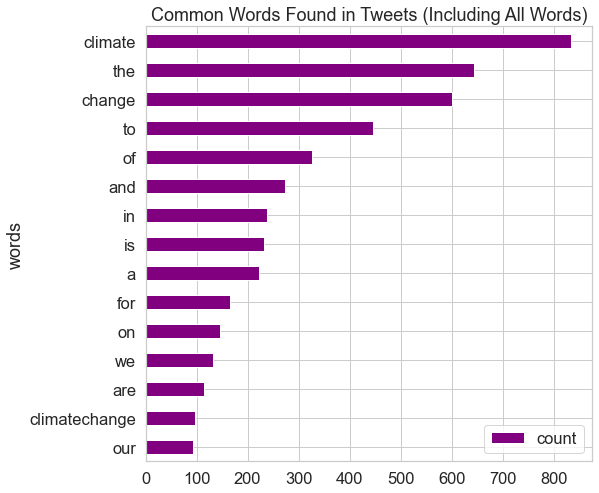

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_no_urls.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Including All Words)")

plt.show()

**Remove Stopwords With nltk**

- In addition to lowercase words, you may also want to perform additional clean-up, such as removing words that do not add meaningful information to the text you are trying to analysis. 
- These words referred to as “stop words” and include commonly appearing words such as who, what, you, etc.

- The Python package nltk, commonly used for text analysis, provides a list of “stop words” that you can use to clean your Twitter data.

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macpro/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
stop_words = set(stopwords.words('english'))

# View a few words from the set
list(stop_words)[0:10]

['do',
 've',
 'their',
 'those',
 'both',
 "doesn't",
 'yourselves',
 "you'll",
 'this',
 'up']

- Notice that the stop words provided by nltk are all lower-case. This works well given you already have converted all of your tweet words to lower case using the Python string method .lower().

- Next, you will remove all stop words from each tweet. First, have a look at the words in the first tweet below.

In [22]:
words_in_tweet[0]

['i',
 'wish',
 'it',
 'was',
 'never',
 'necessary',
 'to',
 'imagine',
 'the',
 'world',
 'without',
 'the',
 'beauty',
 'of',
 'nature',
 'i',
 'hope',
 'that',
 'people',
 'will',
 'understan']

- Below, you remove all of the stop words in each tweet. 
- The list comprehension below might look confusing as it is nested. 
- The list comprehension below is the same as calling:

for all_words in words_in_tweet:

    for  word in all_words:
        #remove stop words

- Now, compare the words in the original tweet to the words in the tweet after the stop words are removed:

In [23]:
# Remove stop words from each tweet list of words
tweets_nsw = [[word for word in tweet_words if not word in stop_words]
              for tweet_words in words_in_tweet]

tweets_nsw[0]

['wish',
 'never',
 'necessary',
 'imagine',
 'world',
 'without',
 'beauty',
 'nature',
 'hope',
 'people',
 'understan']

- Again, you can flatten your list and create a counter to return the most commonly used words and the number of times that they are used.

In [24]:
all_words_nsw = list(itertools.chain(*tweets_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('climate', 833),
 ('change', 601),
 ('climatechange', 96),
 ('environment', 74),
 ('amp', 63),
 ('global', 59),
 ('earth', 48),
 ('people', 47),
 ('climatecrisis', 40),
 ('globalwarming', 39),
 ('energy', 35),
 ('news', 34),
 ('report', 34),
 ('links', 32),
 ('action', 32)]

Then, you can create the Pandas Dataframe and plot the word frequencies without the stop words.

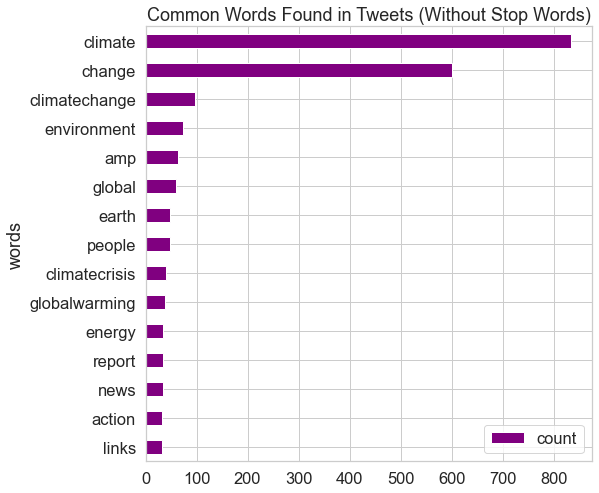

In [25]:
clean_tweets_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop Words)")

plt.show()

**Remove Collection Words**

- In additional to removing stopwords, it is common to also remove collection words. Collection words are the words that you used to query your data from Twitter.

- In this case, you used “climate change” as a collection term. Thus, you can expect that these terms will be found in each tweet. This could skew your word frequency analysis.

- Below you remove the collection words - climate, change, and climatechange - from the tweets through list comprehension

In [26]:
collection_words = ['climatechange', 'climate', 'change']
tweets_nsw_nc = [[w for w in word if not w in collection_words]
                 for word in tweets_nsw]

- Compare the words in first tweet with and without the collection words.

In [27]:
tweets_nsw[0]

['wish',
 'never',
 'necessary',
 'imagine',
 'world',
 'without',
 'beauty',
 'nature',
 'hope',
 'people',
 'understan']

In [28]:
tweets_nsw_nc[0]

['wish',
 'never',
 'necessary',
 'imagine',
 'world',
 'without',
 'beauty',
 'nature',
 'hope',
 'people',
 'understan']

**Calculate and Plot Word Frequency of Clean Tweets**

- Now that you have cleaned up your data, you are ready to calculate and plot the final word frequency results.

- Using the skills you have learned, you can flatten the list and create the counter for the words in the tweets.

In [29]:
# Flatten list of words in clean tweets
all_words_nsw_nc = list(itertools.chain(*tweets_nsw_nc))

# Create counter of words in clean tweets
counts_nsw_nc = collections.Counter(all_words_nsw_nc)

counts_nsw_nc.most_common(15)

[('environment', 74),
 ('amp', 63),
 ('global', 59),
 ('earth', 48),
 ('people', 47),
 ('climatecrisis', 40),
 ('globalwarming', 39),
 ('energy', 35),
 ('news', 34),
 ('report', 34),
 ('links', 32),
 ('action', 32),
 ('time', 30),
 ('new', 30),
 ('science', 28)]

- To find out the number of unique words across all of the tweets, you can take the len() of the object counts that you just created.

In [30]:
len(counts_nsw_nc)

3868

- Last, you can create the Pandas Dataframe of the words and their counts and plot the top 15 most common words from the clean tweets (i.e. no URLs, stop words, or collection words).

In [31]:
clean_tweets_ncw = pd.DataFrame(counts_nsw_nc.most_common(15),
                             columns=['words', 'count'])
clean_tweets_ncw.head()

,words,count
0,environment,74
1,amp,63
2,global,59
3,earth,48
4,people,47


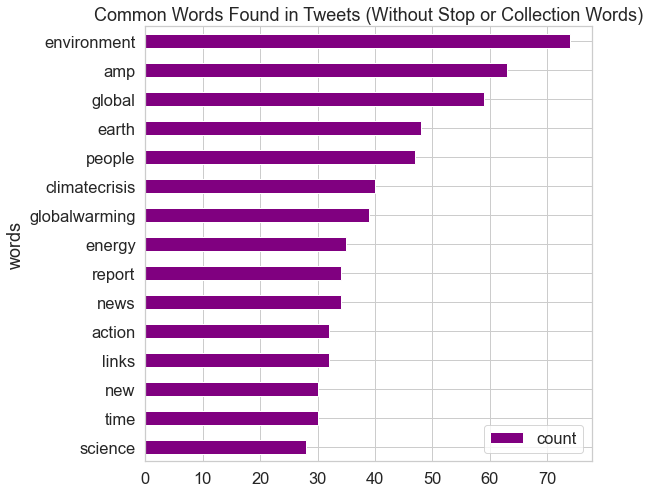

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_tweets_ncw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Tweets (Without Stop or Collection Words)")

plt.show()